In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# Classification d'image

Dans ce tutoriel nous allons étudier plus en détail comment construire un réseau simple à l'aide de pytorch : [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) créé par Yann LeCun.
Le code présent dans ce tutoriel est basé sur un [exemple](https://github.com/pytorch/examples/blob/master/mnist/main.py) écrit en langage `pytorch`.

Ce réseau est un réseau convolutif qui à pour but de faire de la classification d'image.

Ce [tuto](https://www.superdatascience.com/blogs/the-ultimate-guide-to-convolutional-neural-networks-cnn) vous permettra d'aller plus en détail dans l'explication de ce réseau

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

torch.manual_seed(1)
use_cuda = torch.cuda.is_available()

## étape 1 : définition des image train et eval

Il est important pour commencer de définir les images sur lequel nous allons travailler.
Ici, nous travaillerons sur le dataset MNIST, contenant des images de chiffres écrit à la main.

![MNIST](https://knowm.org/wp-content/uploads/Screen-Shot-2015-08-14-at-2.44.57-PM.png)

Le réseau aura pour but de déterminer quel chiffre est écrit sur l'image. Pour cela il vas faloir qu'il apprenne à classifier corectement les images avec un dataset d'entraînement. Il pourra ensuite tester son apprentissage avec un second dataset (dit de validation).

(Ces deux dataset doivent être différents.)

In [3]:
# taille du batch d'entrainement
train_batch_size = 64
# taille du batch de test
test_batch_size = 1000

# transformation des datas
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}


# importation du dataset
dataset = datasets.MNIST('images', download=False, transform=transform)

# nombre d'image pour l'entraînement (80% des données totales)
nb_train = int(0.8*len(dataset))
# nombre d'image pour le test (le reste des données)
nb_test  = len(dataset)-nb_train

# separation des données en deux datasets
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [nb_train, nb_test])


# Chargement des données
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size,  shuffle=True, **kwargs)

In [4]:
print("Le set d'entraînement contient {} images, dans {} batches de {} images".format(len(train_loader.dataset),
                                                                                      len(train_loader),
                                                                                      train_batch_size))
print("Le set de test contient {} images, dans {} batches de {} images".format(len(test_loader.dataset),
                                                                               len(test_loader),
                                                                               test_batch_size))

Le set d'entraînement contient 48000 images, dans 750 batches de 64 images
Le set de test contient 12000 images, dans 12 batches de 1000 images


## étape 2 : Réseau

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1) # convolution 1
        self.conv2 = nn.Conv2d(20, 50, 5, 1) # convolution 2
        self.fc1 = nn.Linear(4*4*50, 500) # fully connected 1
        self.fc2 = nn.Linear(500, 10) # fully connected 2

    def forward(self, x):
        # Extraction de caractéristiques 1
        x = F.relu(self.conv1(x)) # activation
        x = F.max_pool2d(x, 2, 2) # pooling
        
        # Extraction de caractéristiques 2
        x = F.relu(self.conv2(x)) # activation
        x = F.max_pool2d(x, 2, 2) # pooling
        x = x.view(-1, 4*4*50) # flattening
        
        # Classification
        x = F.relu(self.fc1(x)) # activation
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

le réseau LeNet comprend deux principales étapes :
- l'extraction des caractéristique de l'image
- la classification de cette image en fonction de ses caractéristiques

<img src="https://miro.medium.com/max/3712/1*7K4ZTTfZb-hbjoADbisHAg.png" width="600"/>

### rappels sur l'extraction des caractéristique de l'image

pour extraire ses caractéristiques l'image vas subir une série de modification : 

- une **convolution** (voir [Conv2d](https://pytorch.org/docs/stable/nn.html#conv2d), [paramêtres en image](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md))
     - une convolution est une fonction dérivée de deux fonctions données par intégration qui exprime comment la forme de l'une est modifiée par l'autre
     - l'image est convoluée par des détecteurs de caractéristiques (appelés kernel)
     - Attention l'entrée chaque couche de convolution doit faire la même taille que la sortie de la couche de convolution précédante

- une **fonction d'activation** : fonction d'Unité de Rectification Linéaire (voir [ReLu()](https://pytorch.org/docs/stable/nn.html#relu))
    - pour ne garder que les valeurs positives dans les carte de caratéristiques engendré par la convolution
    - ReLU(x)=max(0,x) <img src="https://pytorch.org/docs/stable/_images/ReLU.png" width="400"/>



- un **Pooling** : Max Pooling (voir [MaxPool2d](https://pytorch.org/docs/stable/nn.html#maxpool2d))
    - pour ne garder que les valeurs maximales dans une zone
    - réduit les carte de caractéristique
<img src="https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png" width="300"/>

In [6]:
model = Net()

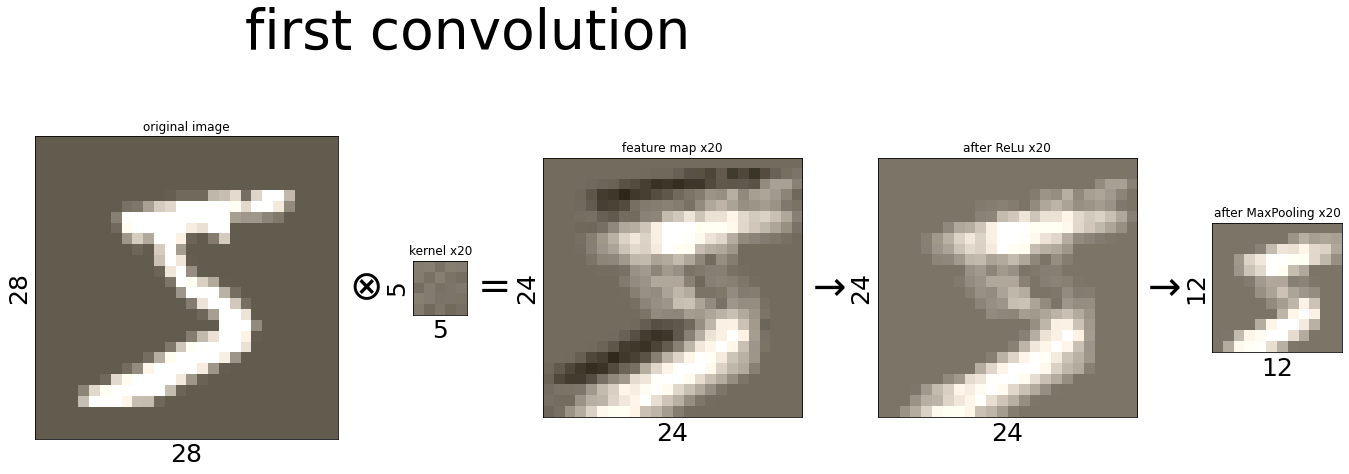

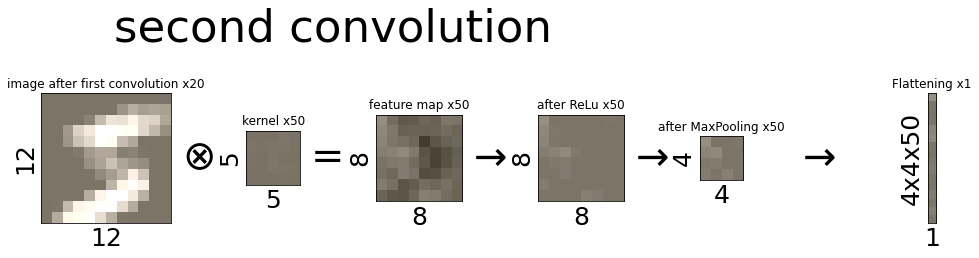

In [7]:
trial = 0
first_featuremap = 0
second_featuremap = 0

from Model_show import Plot_model
Plot_model(dataset, model.to('cpu'), trial, first_featuremap, second_featuremap)

### Classification

- **fully connected** - Linear (voir [Linear](https://pytorch.org/docs/stable/nn.html#linear))
    - c'est un réseau dans lequel tous les neurones de sorties sont connectés à tous les neurones d'entrée
    - Applique une transformation linéaire aux données entrantes
<img src="https://jdlm.info/assets/driverless/27-fully-connected.png" width="900"/>     

- log_softmax (voir [log_softmax](https://pytorch.org/docs/stable/nn.functional.html#log-softmax))

## étape 3 : Entrainement du Réseau

- définition **Fonction loss** + trouver la bonne ! [wiki](https://fr.wikipedia.org/wiki/R%C3%A9seau_neuronal_convolutif)

    La couche de perte spécifie comment l'entrainement du réseau pénalise l'écart entre le signal prévu et réel. Elle est normalement la dernière couche dans le réseau.

    Diverses fonctions de perte adaptées à différentes tâches peuvent y être utilisées [loss-functions](https://pytorch.org/docs/stable/nn.functional.html#loss-functions) :
    - La perte « Softmax »est utilisée pour prédire une seule classe parmi K classes mutuellement exclusives.
    - La perte par entropie croisée sigmoïde est utilisée pour prédire K valeurs de probabilité indépendante dans [0,1].
    - La perte euclidienne est utilisée pour régresser vers des valeurs réelles dans [-inf ,inf].

The negative log likelihood loss -> permet de maximiser l'erreur quand le bon label a une probabilité faible et de la diminuer quand bon label a probabilité élevé !

- **Backpropagation**
    - l'erreur calculer se propage dans les première couche du réseau
<img src="https://d3i71xaburhd42.cloudfront.net/db39fd79bb591b04d33207992f6ccde03cabd861/7-Figure1-1.png" width="400"/>

    - Pour effectuer la backpropagation en pytorch, les étapes suivantes sont nécessaires à chaque itération de la boucle :

        1. **optimizer.zero_grad()** : remet à zero les gradiants de chaque paramètre.
        2. **loss.backward()** : calcule les gradiants pour chaque variable par backpropagation en fonction de la loss, et les stocke dans l’objet Variable
        3. **optimizer.step()** : Modifie chaque paramètre du modèle (poids des réseaux) de manière à minimiser la loss.



In [8]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train() # mettre en mode entrainement
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad() # important ! remet les gradients à 0
        output = model(data) # calcule la prédiction
        loss = F.nll_loss(output, target) # calcule l'erreur : The negative log likelihood loss.
        loss.backward() # dérive le graphe
        optimizer.step() # effectue une étape d'optimisation
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [9]:
# on indique au modèle si on veux travailler sur un GPU ou un CPU
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)

# l'optimiseur permet de mettre calculer les poids du réseau
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

train(model, device, train_loader, optimizer, 0, 749)

Train Epoch: 0 [0/48000 (0%)]	Loss: 2.341338
Train Epoch: 0 [47936/48000 (100%)]	Loss: 0.065021


## étape 3 : Test du Réseau

In [10]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct/len(test_loader.dataset)))
    return(100. * correct/len(test_loader.dataset))

on vas tester le modèle pour 15 essais

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


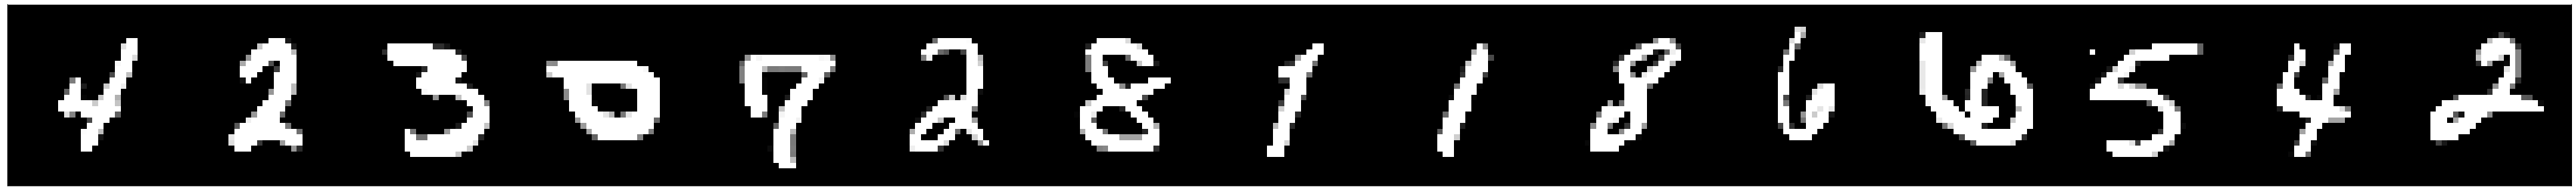

target : tensor([4, 2, 3, 0, 7, 2, 8, 1, 1, 8, 6, 6, 5, 4, 2]) 
prediction : tensor([4, 2, 3, 0, 7, 2, 8, 1, 1, 8, 6, 6, 5, 4, 2]) 
number of good predictions : 15 
total number predictions : 15


In [11]:
N_test = 15
dict_test = dict(iter(test_loader))
inps = list(dict_test.keys())
inp = inps[0][:N_test]
targ = dict_test[inps[0]][:N_test]

i = inp.view(inp.shape[0], 1, inp.shape[2], inp.shape[3])

import torchvision.utils as vutils
grid_images = vutils.make_grid(i, nrow=N_test)
images = np.transpose(grid_images, (1,2,0))

plt.figure(figsize=(5*N_test, 5))
plt.imshow(images)
plt.xticks([]) ; plt.yticks([])
plt.show()


out = model(i.to(device))
pred = out.argmax(dim=1, keepdim=True)
print('target :', targ,
      '\nprediction :', pred.to('cpu').view(-1),
      '\nnumber of good predictions :', pred.eq(targ.to(device).view_as(pred)).sum().item(),
      '\ntotal number predictions :', N_test)      

## étape 4 : évolution de l'erreur au cour de l'apprentissage

on entraine le modèle sur plusieurs epoch en le testant pour chaque epoch afin de voir sont évolution

In [12]:
# on indique au modèle si on veux travailler sur un GPU ou un CPU
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
# l'optimiseur permet de mettre calculer les poids du réseau
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [13]:
#########################################################
# pour remmettre a zeros les poids dans le modèle !
#########################################################
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

model.apply(weight_reset)
#########################################################

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [14]:
epochs = 15
log_interval = 749

list_accuracy = []
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    accuracy = test(model, device, test_loader)
    list_accuracy.append(accuracy)


Train Epoch: 1 [0/48000 (0%)]	Loss: 2.270189
Train Epoch: 1 [47936/48000 (100%)]	Loss: 0.090869

Test set: Average loss: 0.1265, Accuracy: 11522/12000 (96%)

Train Epoch: 2 [0/48000 (0%)]	Loss: 0.160347
Train Epoch: 2 [47936/48000 (100%)]	Loss: 0.207095

Test set: Average loss: 0.0783, Accuracy: 11708/12000 (98%)

Train Epoch: 3 [0/48000 (0%)]	Loss: 0.090742
Train Epoch: 3 [47936/48000 (100%)]	Loss: 0.094107

Test set: Average loss: 0.0675, Accuracy: 11758/12000 (98%)

Train Epoch: 4 [0/48000 (0%)]	Loss: 0.043757
Train Epoch: 4 [47936/48000 (100%)]	Loss: 0.125298

Test set: Average loss: 0.0575, Accuracy: 11796/12000 (98%)

Train Epoch: 5 [0/48000 (0%)]	Loss: 0.171810
Train Epoch: 5 [47936/48000 (100%)]	Loss: 0.024727

Test set: Average loss: 0.0498, Accuracy: 11811/12000 (98%)

Train Epoch: 6 [0/48000 (0%)]	Loss: 0.059161
Train Epoch: 6 [47936/48000 (100%)]	Loss: 0.043079

Test set: Average loss: 0.0433, Accuracy: 11837/12000 (99%)

Train Epoch: 7 [0/48000 (0%)]	Loss: 0.017244
Train E

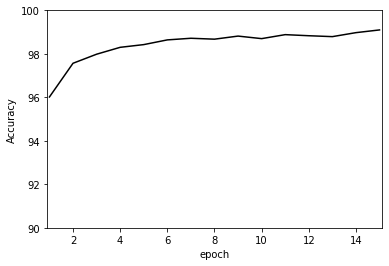

In [15]:
plt.plot(np.arange(1,len(list_accuracy)+1), list_accuracy, 'k')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.axis([0.9,len(list_accuracy)+0.1,90,100]);

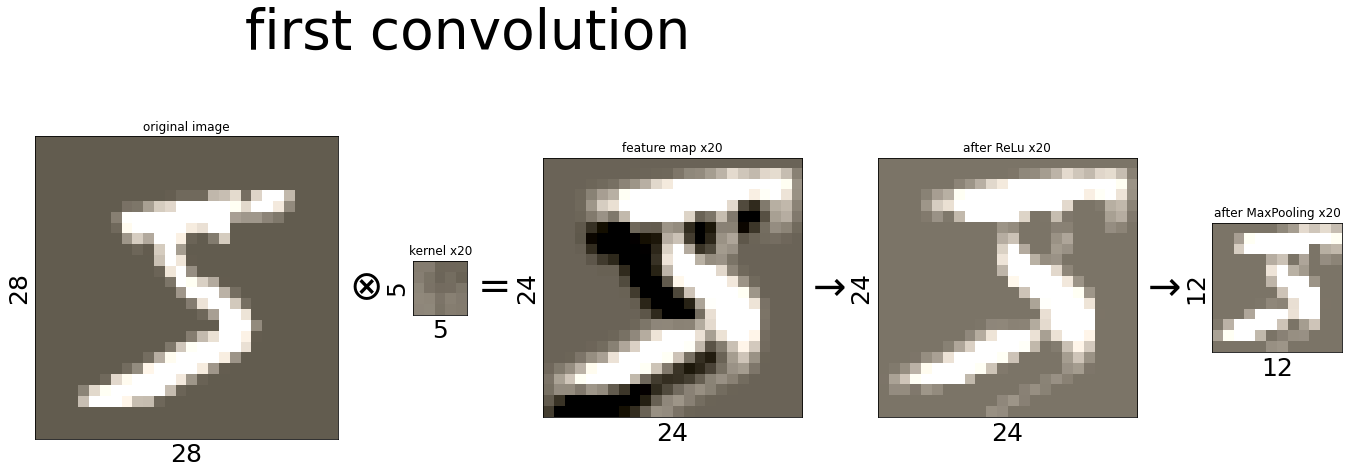

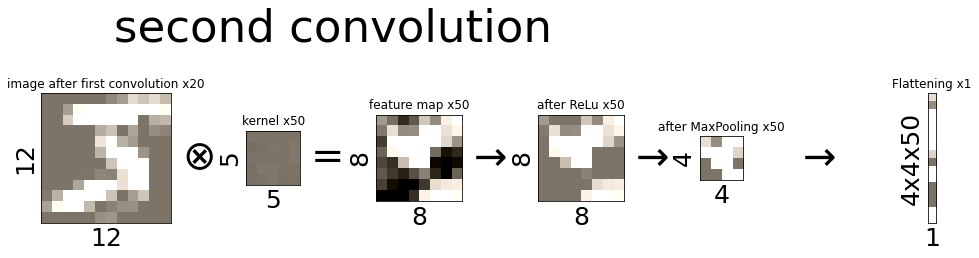

In [16]:
trial = 0
first_featuremap = 0
second_featuremap = 0

Plot_model(dataset, model.to('cpu'), trial, first_featuremap, second_featuremap)

## Visualisation des Kernels des deux convolutions du réseau

Les kernels utilisé par le modèle sont stockés dans :
- `model.conv1.weight` pour le première convolution
- `model.conv2.weight` pour la deuxième convolution

In [17]:
from Model_show import transform_img

**Tous les kernel de la convolution 1 :**

In [18]:
model.conv1.weight.shape

torch.Size([20, 1, 5, 5])

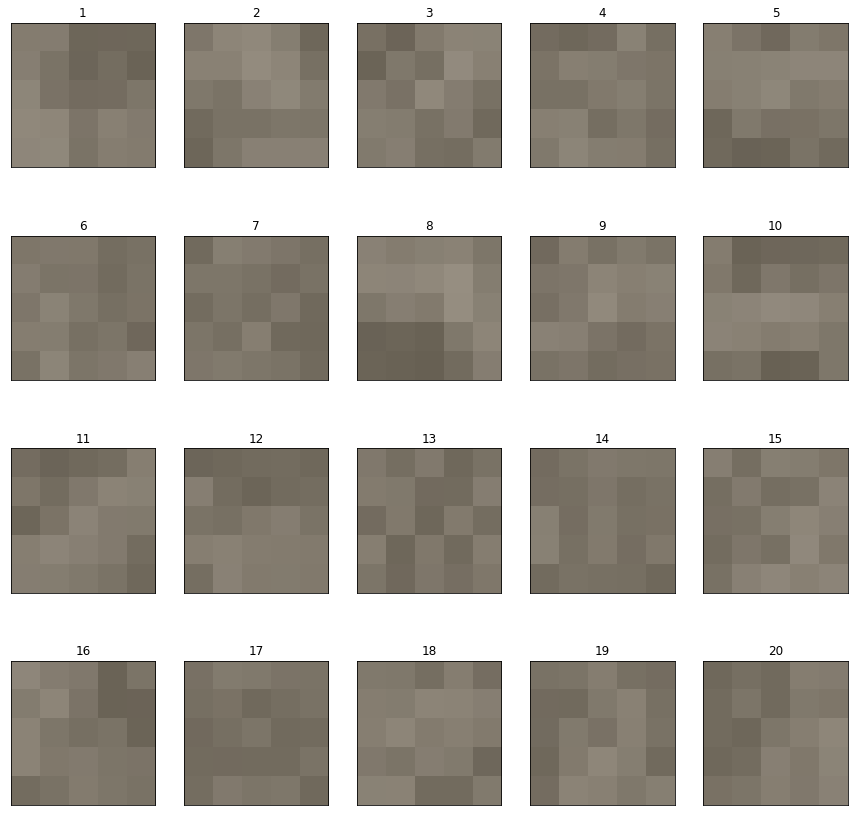

In [19]:
fig, ax = plt.subplots(4,5, figsize=(15,15))
for num_w in range(model.conv1.weight.shape[0]) :
    w = model.conv1.weight[num_w].to('cpu')
    
    a, b = num_w//5, num_w%5
    ax[a][b].imshow(transform_img(w), cmap='magma')
    ax[a][b].set_title(num_w+1)
    ax[a][b].set_xticks([]) ; ax[a][b].set_yticks([])
plt.show()

**Tous les kernel de la convolution 2 pour les cartes de caratéristique du première kernel de la convolution 1 :**

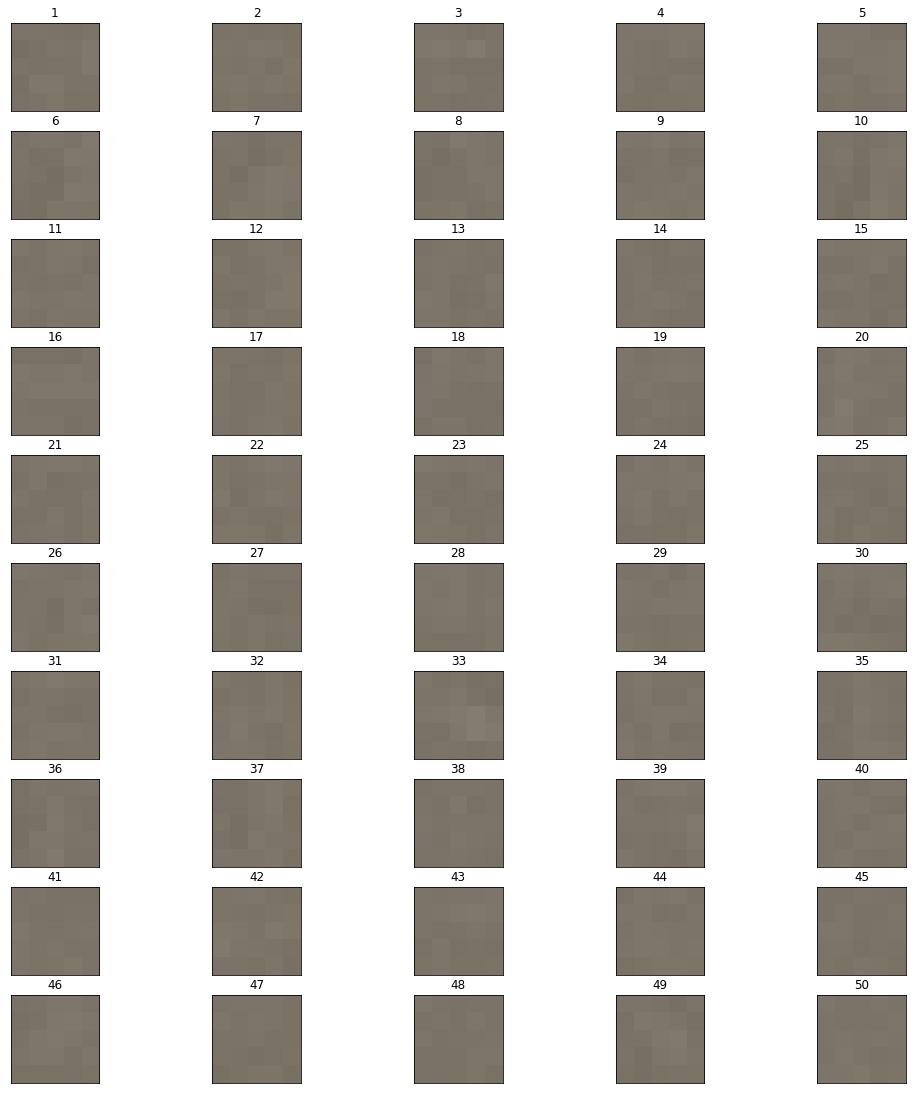

In [20]:
fig, ax = plt.subplots(10,5, figsize=(15,15))
for num_w in range(model.conv2.weight.shape[0]) :
    w = model.conv2.weight[num_w][0].view(1,5,5).to('cpu')
    
    a, b = num_w//5, num_w%5
    ax[a][b].imshow(transform_img(w))
    ax[a][b].set_title(num_w+1)
    ax[a][b].set_xticks([]) ; ax[a][b].set_yticks([])
plt.tight_layout(pad=0)
plt.show()